In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm

/homes/iws/amousavi/miniconda3/envs/mynlpenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(31337);
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}

In [3]:
images = torchvision.datasets.ImageFolder("./images/Images")

In [4]:
labels = []
for label in images.classes:
    labels.append(label)
print(labels)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [6]:
test_size = int(len(images)*0.15)
validation_size = int(len(images)*0.15)
train_size = len(images) - test_size - validation_size
print(train_size, validation_size, test_size)
train_images, validation_images, test_images = torch.utils.data.random_split(images, [train_size, validation_size, test_size])

14406 3087 3087


In [7]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(227, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
train_dataset = TransformedDataset(train_images, data_transforms['train'])
validation_dataset = TransformedDataset(validation_images, data_transforms['validation'])
test_dataset = TransformedDataset(test_images, data_transforms['test'])

In [10]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, **kwargs)
validationloader = torch.utils.data.DataLoader(dataset=validation_dataset, shuffle=False, batch_size=batch_size, **kwargs)

In [11]:
model = models.resnet34(pretrained=True)
in_count = model.fc.in_features
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(in_count, len(labels)),
    nn.LogSoftmax(dim=1)
)
# model = model.to(device)

# model = models.squeezenet1_1(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# num_features = model.classifier[1].in_channels
# # features = list(model.classifier.children())[:-3] # Remove last 3 layers
# # features.extend([nn.Conv2d(num_features, len(all_labels), kernel_size=1)]) # Add
# # features.extend([nn.ReLU(inplace=True)]) # Add
# # features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add
# model.classifier = nn.Sequential(
#     nn.Linear(num_features, len(labels)),
#     nn.LogSoftmax(dim=1)
# ) # Replace the model classifier
# model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0, weight_decay = 0.0001)
opt_func = torch.optim.SGD

training_losses = []
validation_losses = []
validation_accuracies = []

In [14]:
for epoch in range(15):  # loop over the dataset multiple times
    training_loss_epoch = 0
    validation_loss_epoch = 0
    validation_correct = 0
    validation_total = 0
    for batch in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        training_loss_epoch += loss.item()
        optimizer.step()
    for batch in tqdm(validationloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        validation_loss_epoch += loss.item()
        count = torch.eq(torch.argmax(outputs.data, dim=1), labels).sum().item()
        validation_correct += count
        validation_total += labels.size(0)
    training_loss_epoch /= len(trainloader)
    validation_loss_epoch /= len(validationloader)
    training_losses.append(training_loss_epoch)
    validation_losses.append(validation_loss_epoch)
    validation_accuracy_epoch = 100.0 * float(validation_correct) / validation_total
    validation_accuracies.append(validation_accuracy_epoch)
    print("epoch: ", epoch + 1)
    print("training loss: ", training_loss_epoch)
    print("validation loss: ", validation_loss_epoch)
    print("validation accuracy: ", validation_accuracy_epoch)

100%|███████████████████████████████████████████| 49/49 [02:03<00:00,  2.51s/it]


epoch:  1
training loss:  3.4143302862623095
validation loss:  2.793965213152827
validation accuracy:  50.34013605442177


100%|███████████████████████████████████████████| 49/49 [02:04<00:00,  2.55s/it]


epoch:  2
training loss:  2.7394856984636426
validation loss:  2.1717438600501238
validation accuracy:  62.61742792355037


100%|███████████████████████████████████████████| 49/49 [01:43<00:00,  2.11s/it]


epoch:  3
training loss:  2.274646463647353
validation loss:  1.7802688102332913
validation accuracy:  68.64269517330742


100%|███████████████████████████████████████████| 49/49 [02:36<00:00,  3.19s/it]


epoch:  4
training loss:  1.9686442476458255
validation loss:  1.5322612913287417
validation accuracy:  70.74829931972789


100%|███████████████████████████████████████████| 49/49 [02:30<00:00,  3.07s/it]


epoch:  5
training loss:  1.7586115640876567
validation loss:  1.3572351178344415
validation accuracy:  72.69193391642371


100%|███████████████████████████████████████████| 49/49 [02:32<00:00,  3.12s/it]


epoch:  6
training loss:  1.6041401039182612
validation loss:  1.2236000056169472
validation accuracy:  75.08908325234856


100%|███████████████████████████████████████████| 49/49 [02:32<00:00,  3.11s/it]


epoch:  7
training loss:  1.4999433038508998
validation loss:  1.1347487349899448
validation accuracy:  75.70456754130224


100%|███████████████████████████████████████████| 49/49 [02:39<00:00,  3.26s/it]


epoch:  8
training loss:  1.4141401809401217
validation loss:  1.0576219193789425
validation accuracy:  77.03271784904437


100%|███████████████████████████████████████████| 49/49 [02:37<00:00,  3.22s/it]


epoch:  9
training loss:  1.328163936074856
validation loss:  1.0028191464287894
validation accuracy:  77.0651117589893


100%|███████████████████████████████████████████| 49/49 [02:34<00:00,  3.14s/it]


epoch:  10
training loss:  1.279678049868187
validation loss:  0.9562422292573112
validation accuracy:  77.68059604794298


100%|███████████████████████████████████████████| 49/49 [02:34<00:00,  3.15s/it]


epoch:  11
training loss:  1.2320747597027668
validation loss:  0.9183012064622373
validation accuracy:  78.26368642695174


100%|███████████████████████████████████████████| 49/49 [02:33<00:00,  3.13s/it]


epoch:  12
training loss:  1.1888945537858304
validation loss:  0.8902392168434299
validation accuracy:  78.52283770651118


100%|███████████████████████████████████████████| 49/49 [02:33<00:00,  3.12s/it]


epoch:  13
training loss:  1.1607720501127496
validation loss:  0.864422872358439
validation accuracy:  78.58762552640104


100%|███████████████████████████████████████████| 49/49 [02:31<00:00,  3.09s/it]


epoch:  14
training loss:  1.1275887689759245
validation loss:  0.8450664135874534
validation accuracy:  79.00874635568513


100%|███████████████████████████████████████████| 49/49 [02:29<00:00,  3.06s/it]

epoch:  15
training loss:  1.0999305427601906
validation loss:  0.8215536274472062
validation accuracy:  79.30029154518951


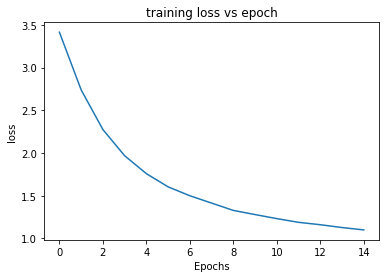

In [15]:
plt.plot(range(len(training_losses)), training_losses)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('training loss vs epoch')
plt.show()
plt.close()

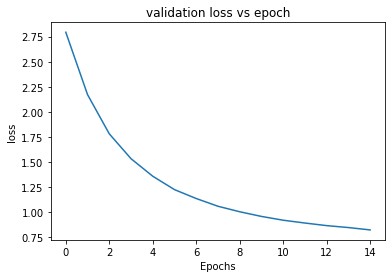

max validation accuracy:  79.30029154518951


In [16]:
plt.plot(range(len(validation_losses)),validation_losses)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('validation loss vs epoch')
plt.show()
plt.close()
print('max validation accuracy: ', max(validation_accuracies))

In [21]:
testloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, **kwargs)

In [22]:
test_loss = 0
test_correct = 0
test_count = 0
for batch in tqdm(testloader):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
    count =  torch.eq(torch.argmax(outputs.data, dim=1), labels).sum().item()
    test_correct += count
    test_count += labels.size(0)
test_loss /= len(testloader)
test_accuracy = 100.0 * float(test_correct) / test_count
print(test_loss)
print(test_accuracy)

100%|███████████████████████████████████████████| 49/49 [03:39<00:00,  4.48s/it]

0.782062961130726
80.72562358276645


In [23]:
torch.save(model.state_dict(), "./saved_model.pt")